In [5]:
img_path = '/Users/fmb/GitHub/764WildlifeReID/megadescriptor/data/images/size-256/FeralCatsAkl_maxim/20190801_YkbM_AucklandIsland__C2_1_14_SD56_20190227_02240028_20190224034315_2327.JPG'

In [2]:
import imquality
import skimage

print("imquality version:", imquality.__version__)
print("scikit-image version:", skimage.__version__)


imquality version: 1.2.7
scikit-image version: 0.18.3


In [3]:
import cv2
print(cv2.__version__)
print("Quality module available:", hasattr(cv2, 'quality'))

4.10.0
Quality module available: True


In [5]:
import cv2

# Print OpenCV version
print(f"OpenCV Version: {cv2.__version__}")

# Check if 'quality' module is available
if hasattr(cv2, 'quality'):
    print("cv2.quality module is available.")
    # List available attributes in cv2.quality
    print("Available attributes in cv2.quality:", dir(cv2.quality))
    # Check for QualityNIQE_create and QualityPIQE_create
    if hasattr(cv2.quality, 'QualityNIQE_create'):
        print("QualityNIQE_create is available.")
    else:
        print("QualityNIQE_create is NOT available.")

    if hasattr(cv2.quality, 'QualityPIQE_create'):
        print("QualityPIQE_create is available.")
    else:
        print("QualityPIQE_create is NOT available.")
else:
    print("cv2.quality module is NOT available.")


OpenCV Version: 4.10.0
cv2.quality module is available.
Available attributes in cv2.quality: ['QualityBRISQUE', 'QualityBRISQUE_compute', 'QualityBRISQUE_computeFeatures', 'QualityBRISQUE_create', 'QualityBase', 'QualityGMSD', 'QualityGMSD_compute', 'QualityGMSD_create', 'QualityMSE', 'QualityMSE_compute', 'QualityMSE_create', 'QualityPSNR', 'QualityPSNR_compute', 'QualityPSNR_create', 'QualitySSIM', 'QualitySSIM_compute', 'QualitySSIM_create', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_native']
QualityNIQE_create is NOT available.
QualityPIQE_create is NOT available.


In [1]:
import cv2
import warnings
import numpy as np
from pathlib import Path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import rgb2gray
from imquality import brisque
from imageio import imread
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

/Library/anaconda3/envs/improc/lib/python3.8/site-packages/libsvm/svm.py:149: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def csr_to_problem_jit(l, x_val, x_ind, x_rowptr, prob_val, prob_ind, prob_rowptr, indx_start):


In [2]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='skimage.color')

In [3]:
def load_image_as_rgb(image_path):
    """Load image and ensure it's in RGB format."""
    image_pil = Image.open(image_path)
    if image_pil.mode != 'RGB':
        image_pil = image_pil.convert('RGB')
    return np.array(image_pil)

def convert_to_grayscale(image):
    """Convert image to grayscale if it's not already."""
    if image.ndim == 3 and image.shape[2] == 3:
        return rgb2gray(image)
    elif image.ndim == 2:
        return image
    else:
        raise ValueError("Unsupported image format!")

In [4]:
def calculate_metrics(image_path, retry_on_error=True):
    """
    Calculate BRISQUE scores for a single image with error handling.
    Lower scores indicate better quality for all metrics.
    
    Parameters:
        image_path (str or Path): Path to the image file.
        retry_on_error (bool): Whether to retry in case of errors during NIQE/PIQE computation.
        
    Returns:
        dict: A dictionary containing the image name and its quality metrics.
    """
    metrics = {'image': Path(image_path).name}
    
    # Calculate BRISQUE
    try:
        image_rgb = load_image_as_rgb(image_path)
        image_gray = convert_to_grayscale(image_rgb)
        metrics['brisque'] = brisque.score(image_gray)
    except Exception as e:
        metrics['brisque'] = None
        print(f"BRISQUE calculation failed for {image_path}: {e}")

    return metrics

In [5]:
calculate_metrics(img_path)

NameError: name 'img_path' is not defined

In [6]:
def process_collection(directory_path, collection_name, handle_none='drop'):
    """Process all images in a directory and return metrics as DataFrame."""
    image_files = [f for f in directory_path.iterdir() if (f.is_file() and f.suffix == '.JPG')]
    
    if not image_files:
        raise ValueError(f"No supported image files found in {directory_path}")
    
    results = []
    failed_images = []
    
    for img_path in image_files:
        metrics = calculate_metrics(img_path)
        if metrics is not None:
            metrics['collection'] = collection_name
            results.append(metrics)
        else:
            failed_images.append(str(img_path))
    
    if not results:
        raise ValueError("No images were successfully processed")
    
    df = pd.DataFrame(results)
    
    # Handle None values based on specified method
    metrics_columns = ['brisque', 'niqe', 'piqe']
    if handle_none == 'drop':
        df = df.dropna(subset=metrics_columns)
    elif handle_none == 'fill_mean':
        for col in metrics_columns:
            df[col] = df[col].fillna(df[col].mean())
    elif handle_none == 'fill_zero':
        df[df[metrics_columns]] = df[metrics_columns].fillna(0)
    # If handle_none == 'keep', do nothing
    
    # Report on failed calculations
    total_images = len(image_files)
    successful_images = len(df)
    print(f"\nProcessing Summary for {collection_name}:")
    print(f"Total images: {total_images}")
    print(f"Successfully processed: {successful_images}")
    print(f"Failed: {total_images - successful_images}")
    
    if failed_images:
        print("\nFailed images:")
        for img in failed_images:
            print(f"- {img}")
    
    return df

In [12]:
def analyze_collections(collections_dict, handle_none='keep'):
    """
    Analyze multiple collections with specified None handling method.
    
    Args:
        collections_dict: Dictionary mapping collection names to paths
        handle_none: How to handle None values ('drop', 'fill_mean', 'fill_zero', or 'keep')
    """
    all_results = pd.DataFrame()
    
    for name, path in collections_dict.items():
        print(f"\nProcessing {name}...")
        # try:
        df = process_collection(path, name, handle_none)
        all_results = pd.concat([all_results, df], ignore_index=True)
        # except Exception as e:
        # print(f"Error processing collection {name}: {e}")
    
    print(">> Analysis Done")
    return all_results

In [33]:
def visualize_collections_comparison(df):
    """Create visualizations comparing metrics across collections."""
    metrics = ['brisque', 'niqe', 'piqe']
    
    # Set up the plotting style
    sns.set_style("whitegrid")
    
    # Create figure with proper number of subplots
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    
    # Convert axes to array if there's only one metric
    if len(metrics) == 1:
        axes = [axes]
    
    # Create box plots for each metric
    for i, metric in enumerate(metrics):
        if metric in df.columns:  # Only plot metrics that exist in the dataframe
            sns.boxplot(data=df, x='collection', y=metric, ax=axes[i])
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
            axes[i].set_title(f"{metric.upper()} Scores by Collection")
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display summary statistics for existing metrics
    existing_metrics = [m for m in metrics if m in df.columns]
    if existing_metrics:
        summary_stats = df.groupby('collection')[existing_metrics].agg(['count', 'mean', 'std', 'min', 'max'])
        print("\nSummary Statistics:")
        display(summary_stats)
        
        # Create correlation plot if we have more than one metric
        if len(existing_metrics) > 1:
            plt.figure(figsize=(8, 6))
            sns.heatmap(df[existing_metrics].corr(), annot=True, cmap='coolwarm', center=0)
            plt.title("Correlation between Metrics")
            plt.show()
    
    # Save results to CSV
    df.to_csv("collection_metrics.csv", index=False)
    print("\nResults saved to collection_metrics.csv")
    
    return summary_stats

In [10]:
images_root = Path('../data/images/size-256')

collections = {
    'FeralCatsAkl_maxim': images_root/'FeralCatsAkl_maxim',
    'FeralCatsAkl_HIDiff': images_root/'FeralCatsAkl_HIDiff',
    'FeralCatsAkl_SRMNet': images_root/'FeralCatsAkl_SRMNet',
}

In [ ]:
# Process all collections and get results
results_df = analyze_collections(collections)

In [14]:
results_df

,image,brisque,collection
0,20190801_F62S_AucklandIsland_B1_4_35_SD135_201...,39.239440,FeralCatsAkl_maxim
1,20190801_nYPb_AucklandIsland_B2_2_1_SD21_20190...,23.059754,FeralCatsAkl_maxim
2,20190801_g7RF_AucklandIsland_C1_6_45_SD125_201...,44.146093,FeralCatsAkl_maxim
3,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,34.870363,FeralCatsAkl_maxim
4,20190801_kW8J_AucklandIsland_A2_3_41_SD15_2019...,22.474983,FeralCatsAkl_maxim
...,...,...,...
5710,20190801_fI6t_AucklandIsland_B2_5_35_SD41_2019...,38.269349,FeralCatsAkl_SRMNet
5711,20190801_iLT8_AucklandIsland_B2_2_1_SD111_2019...,27.401656,FeralCatsAkl_SRMNet
5712,20190801_y7TW_AucklandIsland_D2_6_26_SD63_2019...,6.537698,FeralCatsAkl_SRMNet
5713,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,46.549846,FeralCatsAkl_SRMNet


In [15]:
results_df.to_csv('brisque_scores.csv')

In [18]:
fca_base_dir = images_root/'fca_base'
base_collection = {
    'cat-eat': fca_base_dir / 'cat-eat',
    'cat-ignore':fca_base_dir / 'cat-ignore',
    'cat-interact':fca_base_dir /'cat-interact',
    'collared-eat':fca_base_dir /'collared-eat',
    'collared-ignore':fca_base_dir /'collared-ignore',
    'collared-interact':fca_base_dir /'collared-interact',
}

In [ ]:
baseline_res = analyze_collections(base_collection)

In [22]:
results_df

,image,brisque,collection
0,20190801_F62S_AucklandIsland_B1_4_35_SD135_201...,39.239440,FeralCatsAkl_maxim
1,20190801_nYPb_AucklandIsland_B2_2_1_SD21_20190...,23.059754,FeralCatsAkl_maxim
2,20190801_g7RF_AucklandIsland_C1_6_45_SD125_201...,44.146093,FeralCatsAkl_maxim
3,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,34.870363,FeralCatsAkl_maxim
4,20190801_kW8J_AucklandIsland_A2_3_41_SD15_2019...,22.474983,FeralCatsAkl_maxim
...,...,...,...
5710,20190801_fI6t_AucklandIsland_B2_5_35_SD41_2019...,38.269349,FeralCatsAkl_SRMNet
5711,20190801_iLT8_AucklandIsland_B2_2_1_SD111_2019...,27.401656,FeralCatsAkl_SRMNet
5712,20190801_y7TW_AucklandIsland_D2_6_26_SD63_2019...,6.537698,FeralCatsAkl_SRMNet
5713,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,46.549846,FeralCatsAkl_SRMNet


In [24]:
baseline_res['collection'] = 'baseline'

In [25]:
baseline_res

,image,brisque,collection
0,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,31.252059,baseline
1,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,33.338074,baseline
2,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,29.959135,baseline
3,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,31.179691,baseline
4,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,45.522533,baseline
...,...,...,...
1900,20190801_Y4bG_AucklandIsland_A2_2_38_SD38_2019...,13.307786,baseline
1901,20190801_Y4bG_AucklandIsland_A2_2_38_SD38_2019...,14.862623,baseline
1902,20190801_kW8J_AucklandIsland_A2_3_41_SD15_2019...,52.736976,baseline
1903,20190801_Y4bG_AucklandIsland_A2_2_38_SD38_2019...,45.316846,baseline


In [26]:
full_brisque = pd.concat([results_df, baseline_res])
full_brisque.to_csv('brisque_scores.csv')

In [ ]:
import numpy as np
from imquality import brisque
from imageio import imread
from PIL import Image

def load_image_as_rgb(image_path):
    image_pil = Image.open(image_path)
    if image_pil.mode != 'RGB':
        image_pil = image_pil.convert('RGB')
    return np.array(image_pil)

# Path to your image
image_path = 'path_to_your_image.jpg'

# Load image
image_rgb = load_image_as_rgb(img_path)

# Check shape
print("Image shape:", image_rgb.shape)  # Should be (height, width, 3)

# Compute BRISQUE score
score = brisque.score(image_rgb)
print("BRISQUE score:", score)


NameError: name 'img_path' is not defined

In [44]:
results_df

,image,brisque,niqe,piqe,collection
0,20190801_F62S_AucklandIsland_B1_4_35_SD135_201...,None,None,None,FeralCatsAkl_maxim
1,20190801_nYPb_AucklandIsland_B2_2_1_SD21_20190...,None,None,None,FeralCatsAkl_maxim
2,20190801_g7RF_AucklandIsland_C1_6_45_SD125_201...,None,None,None,FeralCatsAkl_maxim
3,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,None,None,None,FeralCatsAkl_maxim
4,20190801_kW8J_AucklandIsland_A2_3_41_SD15_2019...,None,None,None,FeralCatsAkl_maxim
...,...,...,...,...,...
5710,20190801_fI6t_AucklandIsland_B2_5_35_SD41_2019...,None,None,None,FeralCatsAkl_SRMNet
5711,20190801_iLT8_AucklandIsland_B2_2_1_SD111_2019...,None,None,None,FeralCatsAkl_SRMNet
5712,20190801_y7TW_AucklandIsland_D2_6_26_SD63_2019...,None,None,None,FeralCatsAkl_SRMNet
5713,20190801_4v26_AucklandIsland_A1_2_3_SD98_20190...,None,None,None,FeralCatsAkl_SRMNet


/var/folders/r7/hlvr4tcn43d2pztz8gqr8_sc0000gn/T/ipykernel_50540/3952088622.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


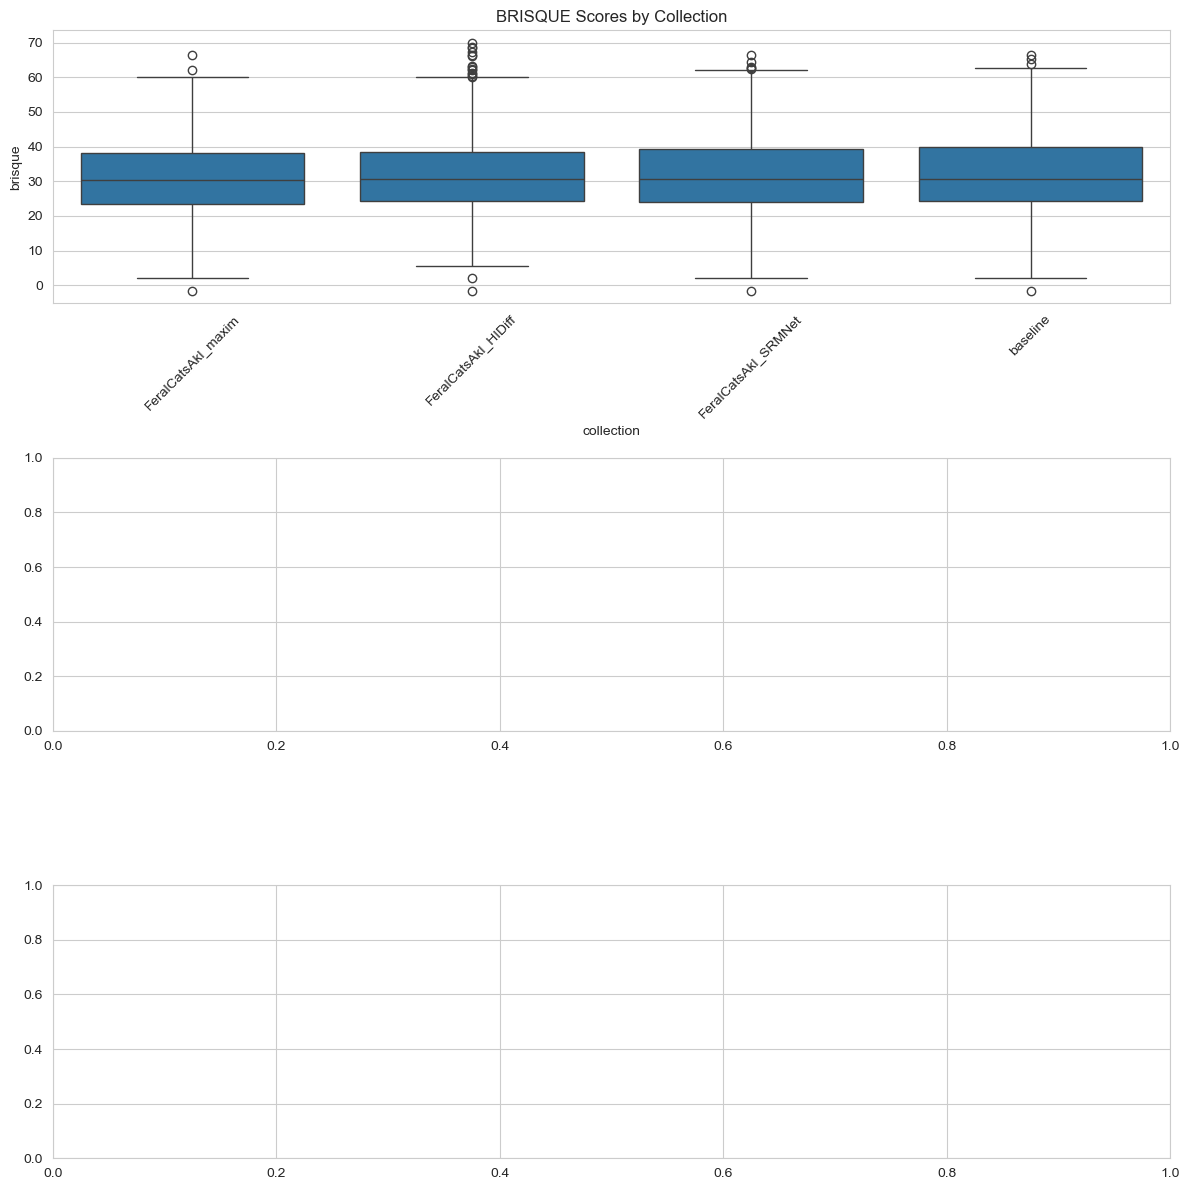


Summary Statistics:


brisque                                           
                      count       mean        std       min        max
collection                                                            
FeralCatsAkl_HIDiff    1905  31.217873  11.639149 -1.703394  69.945170
FeralCatsAkl_SRMNet    1905  31.505056  11.959083 -1.703394  66.540209
FeralCatsAkl_maxim     1905  30.412016  10.851253 -1.703394  66.540209
baseline               1905  31.772603  12.151277 -1.703394  66.540209


Results saved to collection_metrics.csv


brisque                                           
                      count       mean        std       min        max
collection                                                            
FeralCatsAkl_HIDiff    1905  31.217873  11.639149 -1.703394  69.945170
FeralCatsAkl_SRMNet    1905  31.505056  11.959083 -1.703394  66.540209
FeralCatsAkl_maxim     1905  30.412016  10.851253 -1.703394  66.540209
baseline               1905  31.772603  12.151277 -1.703394  66.540209

In [34]:
visualize_collections_comparison(full_brisque)

## Stuff

In [ ]:
import numpy as np
from imquality import brisque
from imageio import imread
from PIL import Image

def load_image_as_rgb(image_path):
    image_pil = Image.open(image_path)
    if image_pil.mode != 'RGB':
        image_pil = image_pil.convert('RGB')
    return np.array(image_pil)

# Path to your image
image_path = 'path_to_your_image.jpg'

# Load image
image_rgb = load_image_as_rgb(img_path)

# Check shape
print("Image shape:", image_rgb.shape)  # Should be (height, width, 3)

# Compute BRISQUE score
score = brisque.score(image_rgb)
print("BRISQUE score:", score)


Image shape: (407, 256, 3)


/Library/anaconda3/envs/improc/lib/python3.8/site-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


BRISQUE score: 38.36207028840826
